<a href="https://colab.research.google.com/github/PinkY-78/Classification_model_cats_and_dogs/blob/main/Classification_of_Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import copy

In [ ]:
#define data transformations for data augmentation and normalization
data_transforms = {
    'train data': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test data': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.484, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
#Define the data directory
data_dir = '/content/drive/MyDrive/Datasets'

In [ ]:
#Create data loaders
import torchvision
img_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train data', 'test data']}

In [ ]:
#Loading the data
dataLoaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size= 32, shuffle=True) for x in ['train data', 'test data']}

In [ ]:
#Dataset size
dataset_sizes = {x: len(img_datasets[x]) for x in ['train data', 'test data']}
print(dataset_sizes)

class_names = img_datasets['train data'].classes
class_names

{'train data': 555, 'test data': 138}


['cats datset', 'dogs dataset']

In [ ]:
#load the pretrained Resnet-50 model
model = models.resnet50(pretrained=True)

#Freeze all layers except the final classification layer
for name, param in model.named_parameters():
  if "fc" in name:   #unfreezing the final layer
    param.requires_grad = True
  else:
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


In [ ]:
#define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9) #use all parameters

In [ ]:
# Move the device to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from copy import deepcopy
#Training loop
num_epochs = 10
best_model_wts = None
best_acc = 0.0
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-'*10)
    for phase in ['train data', 'test data']:
        if phase == 'train data':
            model.train()
            dataloader = dataLoaders[phase]
        else:
            model.eval()
            dataloader = dataLoaders[phase]
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train data'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train data':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase} Loss: {epoch_loss:.4f} Acc {epoch_acc:.4f}')
print("Training complete!")

Epoch 1/10
----------
train data Loss: 4.9443 Acc 0.2703
test data Loss: 0.6383 Acc 0.7174
Epoch 2/10
----------
train data Loss: 0.5365 Acc 0.7640
test data Loss: 0.3414 Acc 0.8768
Epoch 3/10
----------
train data Loss: 0.3305 Acc 0.8559
test data Loss: 0.2475 Acc 0.8841
Epoch 4/10
----------
train data Loss: 0.2529 Acc 0.8937
test data Loss: 0.2114 Acc 0.9058
Epoch 5/10
----------
train data Loss: 0.2400 Acc 0.8973
test data Loss: 0.1853 Acc 0.9058
Epoch 6/10
----------
test data Loss: 0.1769 Acc 0.9275
Epoch 7/10
----------
train data Loss: 0.2067 Acc 0.9243
test data Loss: 0.1572 Acc 0.9348
Epoch 8/10
----------
train data Loss: 0.1982 Acc 0.9225
test data Loss: 0.1494 Acc 0.9348
Epoch 9/10
----------
train data Loss: 0.1862 Acc 0.9207
test data Loss: 0.1730 Acc 0.9275
Epoch 10/10
----------
train data Loss: 0.2009 Acc 0.9135
test data Loss: 0.1339 Acc 0.9493
Training complete!


In [ ]:
# if phase == 'test data' and epoch_acc > best_acc:
#     best_acc = epoch_acc
#     best_model_wts = copy.deepcopy(model.state_dict())
#     print('Best model updated!')

In [ ]:

torch.save(model.state_dict(), 'Animal_classification_model.pth')
print('Model saved!')

Model saved!


**CLASSIFICATION ON UNSEEN DATA**

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

In [ ]:
#Load the save model
model = models.resnet50(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, 1000)
model.load_state_dict(torch.load('/content/Animal_classification_model.pth'))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Create a new model with the correct final layer
new_model = models.resnet50(pretrained = True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Copy the weights and biases from the model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2] # copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

In [ ]:
# Load and preprocess the unseen image
img_path = '/content/testImg1.jpg'
image = Image.open(img_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [ ]:
# Perform inference
with torch.no_grad():
  output = model(input_batch)


In [ ]:
# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
original_class_names = ['cats dataset', 'dogs dataset']
class_names_mapping = {'cats dataset' : 'cat', 'dogs dataset' : 'dog'}

# Get the original predicted class name
original_predicted_class_name = original_class_names[predicted_class.item()]

# Map to the simpler class name
predicted_class_name = class_names_mapping[original_predicted_class_name]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: dog


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


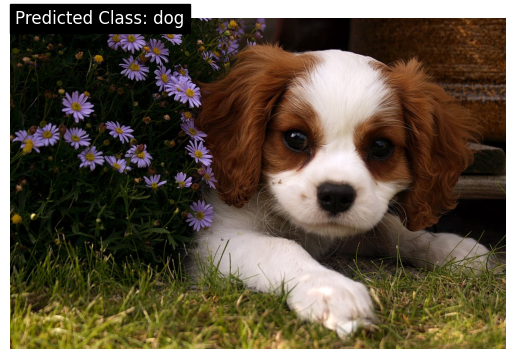

In [ ]:
# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted Class: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='black')
plt.show()
